In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
dataset='https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge'

In [ ]:
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: poshamuppamma
Your Kaggle Key: ··········


100%|██████████| 5.11G/5.11G [00:59<00:00, 92.0MB/s]


In [ ]:
import os

In [ ]:
data_dir='./lyft-udacity-challenge'

In [ ]:
os.listdir(data_dir)

['datae',
 'dataA',
 'dataa',
 'dataD',
 'dataB',
 'dataE',
 'datab',
 'datad',
 'datac',
 'dataC']

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = '/content/lyft-udacity-challenge/dataA/dataA'
image_path = os.path.join(path, 'CameraRGB/')
mask_path = os.path.join(path, 'CameraSeg/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [ ]:
len(image_list)

1000

<ipython-input-11-1c8a0edbb35a>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-11-1c8a0edbb35a>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

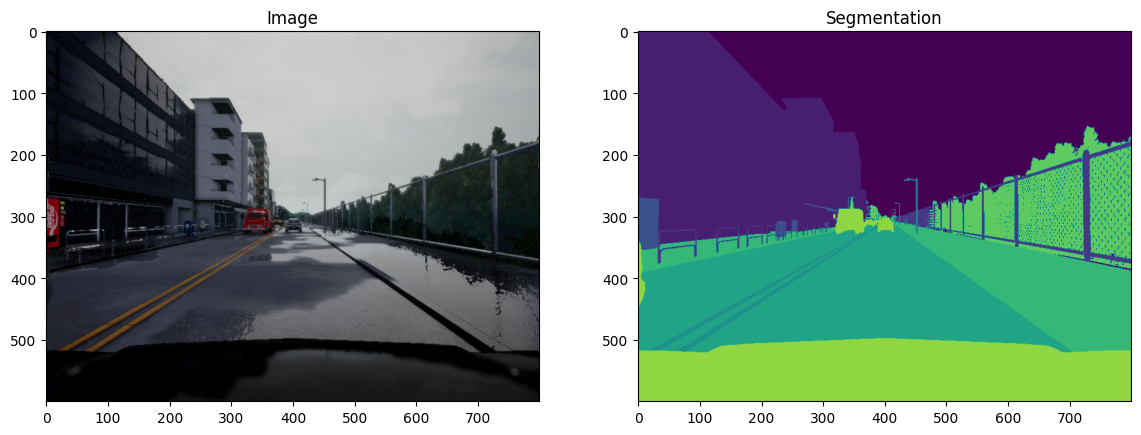

In [ ]:
N = 3
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

 Split Your Dataset into Unmasked and Masked Images

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_010.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_010.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/lyft-udacity-challenge/dataA/dataA/CameraRGB/10_00_151.png', shape=(), dtype=string)
tf.Tensor(b'/content/lyft-udacity-challenge/dataA/dataA/CameraSeg/10_00_151.png', shape=(), dtype=string)


Preprocess Your Data

In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    input_image = input_image / 512

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)



U-**Net**
Encoder (Downsampling Block)
Decoder (Upsampling Block)

> Indented block



In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
   # """
    #Convolutional downsampling block

    #Arguments:
     #   inputs -- Input tensor
      #  n_filters -- Number of filters for the convolutional layers
       # dropout_prob -- Dropout probability
        #max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    #Returns:
     #   next_layer, skip_connection --  Next layer and skip connection outputs
    #"""

    ### START CODE HERE
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    ### END CODE HERE

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
         ### END CODE HERE


    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(2,strides=2)(conv)
        ### END CODE HERE

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [ ]:
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
   # """
    #Convolutional upsampling block

   # Arguments:
    #    expansive_input -- Input tensor from previous layer
     #   contractive_input -- Input tensor from previous skip layer
      #  n_filters -- Number of filters for the convolutional layers
   # Returns:
    #    conv -- Tensor output
    #"""

    ### START CODE HERE
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,# Kernel size
                 strides=2,
                 padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)

    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)

    ### END CODE HERE

    return conv
###########################################

 Build the Model

In [ ]:
# UNQ_C3
# GRADED FUNCTION: unet_model
def unet_model(input_size=(256,256,1), n_filters=32, n_classes=23):
  #  """
   # Unet model

  #  Arguments:
   #     input_size -- Input shape
    #    n_filters -- Number of filters for the convolutional layers
     #   n_classes -- Number of output classes
    #Returns:
     #   model -- tf.keras.Model
   # """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False)

    ### END CODE HERE

    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)


    ### END CODE HERE

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

Set Model Dimensions

In [ ]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

 Loss Function

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

 Dataset Handling
Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible.

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(600, 800, 1)


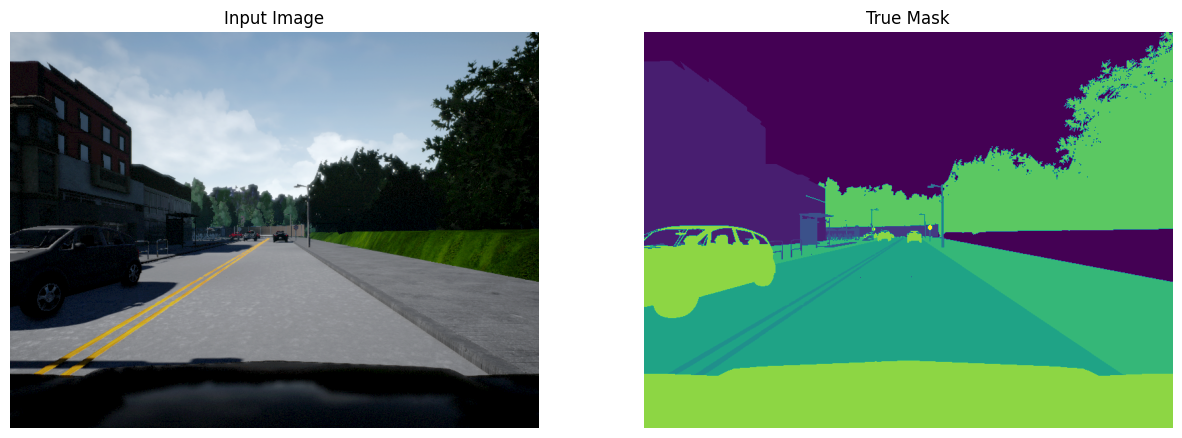

In [ ]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(256, 256, 1)


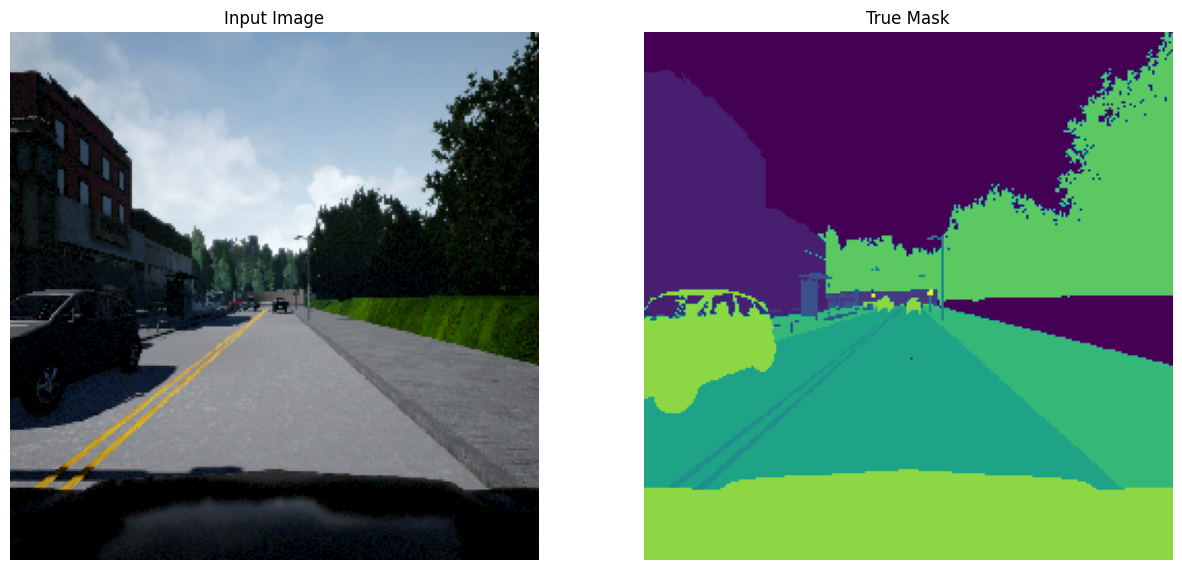

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

Train the Model

In [ ]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/40
32/32 [==============================] - 2575s 79s/step - loss: 3.5744 - accuracy: 0.1820
Epoch 2/40
32/32 [==============================] - 2366s 74s/step - loss: 2.3147 - accuracy: 0.2279
Epoch 3/40
32/32 [==============================] - 2330s 73s/step - loss: 1.8739 - accuracy: 0.3114
Epoch 4/40
21/32 [==================>...........] - ETA: 13:32 - loss: 1.6566 - accuracy: 0.3808

Create Predicted Masks

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

Plot Model Accuracy

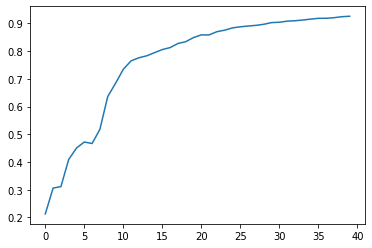

In [ ]:
plt.plot(model_history.history["accuracy"])
#plt.plot(model_history.history["loss"])


In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 277ms/step


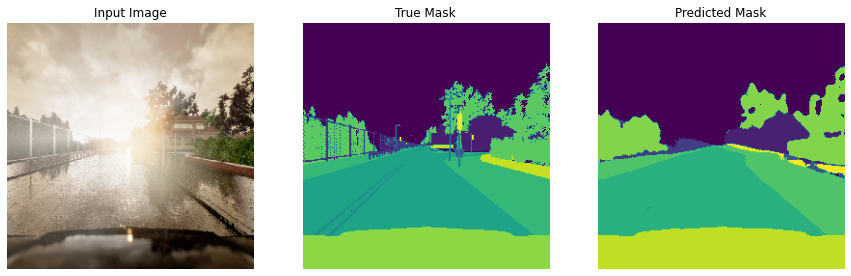

1/1 [==============================] - 0s 45ms/step


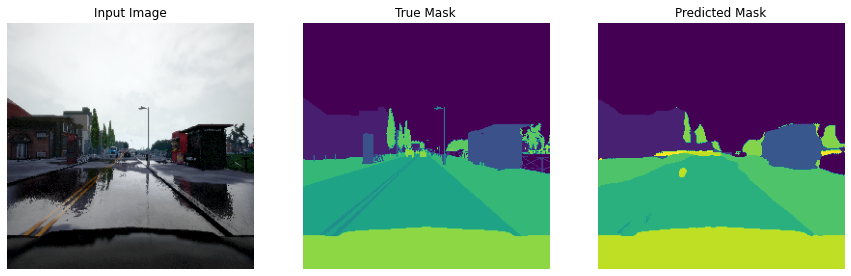

1/1 [==============================] - 0s 35ms/step


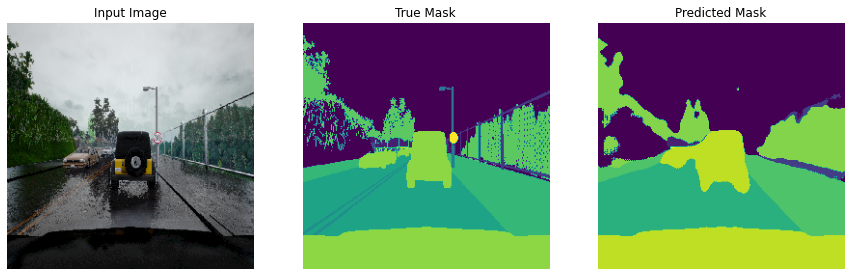

1/1 [==============================] - 0s 35ms/step


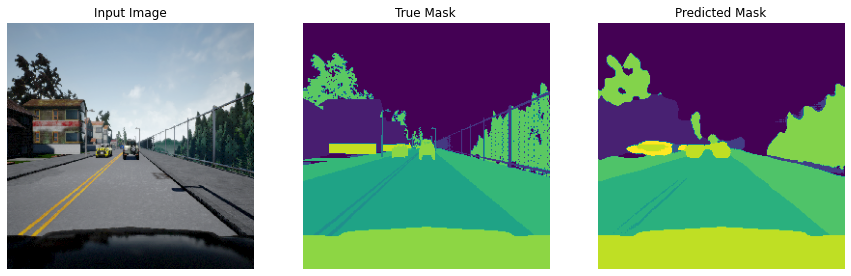

1/1 [==============================] - 0s 47ms/step


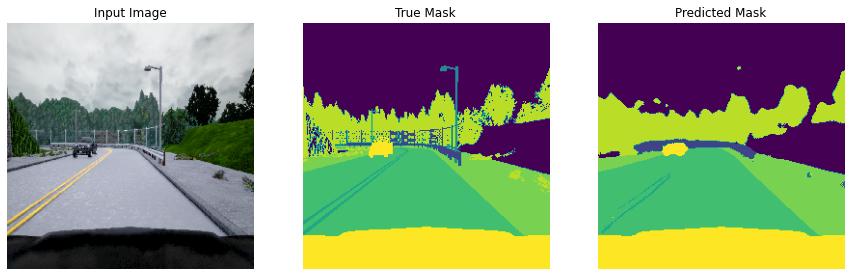

1/1 [==============================] - 0s 36ms/step


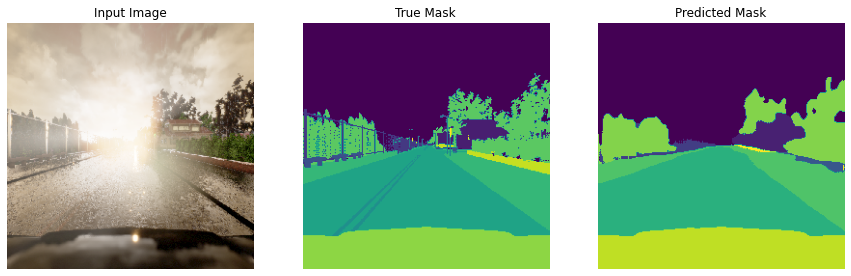

In [ ]:
show_predictions(train_dataset, 6)

FCN Model

In [ ]:
def blck(n_channels,n_layers,n_blck) :

 #   '''
  #  What this function does?
  #  blck function creates a block of convolution layers.

   # Input Arguments:
   # n_channels- Number of channels in the input function call
   # n_blck- Number of the block; used for the layer naming convention
   # n_layers- Number of convolution layers in the block

   # Function return:
   # A sequence of colvolutional layers; followed by a max-pooling layer
   # '''
    Layers = []
    padding="same"
    activation="relu"
    for i in range(n_layers) :
        # Layer name is defined on the basis of the block number, it belongs to
        layer_name = "convblock"+str(n_blck)+"-layer-"+str(i+1)
        #print(layer_name)
        # A (3,3) kernel is used. Hence, (3,3) is mentioned in the second argument of the convolution2D layer definition
        Layers.append(Convolution2D(n_channels,(3,3),activation = activation,name = layer_name,padding=padding))

    layer_name = "convblock"+str(n_blck)+"-pool"

    #Addding max pooling layer
    Layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name = layer_name))

    return Layers

In [ ]:
from keras.models import Sequential
from itertools import permutations
import tensorflow.compat.v2 as tf
from tensorflow.compat.v2.keras.layers import Permute
from skimage import morphology
import numpy as np
import cv2
import glob
import itertools
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add, Activation
from keras.layers.convolutional import Conv2DTranspose
from scipy.io import loadmat
import tensorflow as tf
import numpy as np
from keras.optimizers import Adam, RMSprop
from keras.metrics import categorical_crossentropy,binary_crossentropy
from threading import Thread
import time
from keras import backend as K
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2DTranspose, UpSampling2D
from keras.layers import Input, Add, Dropout, Permute, add, concatenate, Reshape, Activation, BatchNormalization
from scipy.io import loadmat
from keras.layers import PReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, ZeroPadding2D
from keras.layers.core import SpatialDropout2D, Permute, Activation, Reshape
from keras.layers import add, concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
#from keras.engine.topology import Input
from keras.utils.layer_utils import get_source_inputs
from keras.models import Model
#from crfrnn_layer import CrfRnnLayer

from tensorflow.keras.utils import  load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *

In [ ]:
def FCN(input_size,n_classes,fcn_level):

    '''
    What this function does?
    Creates an FCN model using the blck function, coded in the previous cell of the Jupyter notebook

    Input Arguments:
    input_size- Takes the size/dimension of the input image-ex.(Pixels in x-direction, Pixels in y-direction, Number of channels)
    n_classes- Number of output class
    fcn_level- Asks user about the level of upsampling/transpose convolution (it can take 8 or 16 as an argument)

    Function return:
    FCN model respective to the chosen level of upsampling/transpose convolution
    '''
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = (input_size,input_size,3)))

    n_channels_list = [64, 128, 256, 512, 512]

    for i,j in enumerate(n_channels_list):

        if(i<2):
            k = 2
        else:
            k=3

        for layer in blck(j,k,(i+1)) :
            model.add(layer)

    padding="same"
    activation = 'relu'

    model.add(Convolution2D(4096,kernel_size=(7,7),padding=padding,activation = activation,name = "fully_conv_6"))
    model.add(Convolution2D(4096,kernel_size=(1,1),padding=padding,activation = activation,name = "fully_conv_7"))

    model.add(Convolution2D(n_classes,kernel_size=(1,1),padding=padding,activation=activation,name = "prediction_layer"))

    model.add(Conv2DTranspose(n_classes,kernel_size=(4,4),strides = (2,2),padding ="valid",name = "up1"))
    #would need to be defined for a different image size
    model.add(Cropping2D(cropping=((0,2),(0,2))))

    o = model.get_layer('convblock4-pool').output

    skip1 = Convolution2D(n_classes,kernel_size=(1,1),padding =padding, name = "skip1") (o)
    added = add(inputs = [skip1, model.layers[-1].output])

    if(fcn_level==8):
        up2 = Conv2DTranspose(n_classes,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "up2")(added)
        #would need to be defined for a different image size
        up2 = Cropping2D(cropping=((0,2),(0,2)))(up2)

        o = model.get_layer('convblock3-pool').output
        skip2 = Convolution2D(n_classes,kernel_size=(1,1),padding =padding,activation=None, name = "skip2")(o)
        added = add(inputs = [skip2,up2])

        up3 = Conv2DTranspose(n_classes,kernel_size=(16,16),strides = (8,8),
                             padding = "valid",activation = None,name = "up3")(added)

        up3 = Cropping2D(cropping = ((0,8),(0,8)))(up3)

    else:

        up3 = Conv2DTranspose(n_classes,kernel_size=(16,16),strides = (16,16),
                             padding = "valid",activation = None,name = "up3")(added)




    o = (Activation('softmax'))(up3)


    return Model(model.input, o)


In [ ]:
model = FCN(256,1,8)

ResourceExhaustedError: ignored

In [ ]:

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 permute_6_input (InputLayer)   [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 permute_6 (Permute)            (None, 256, 256, 3)  0           ['permute_6_input[0][0]']        
                                                                                                  
 convblock1-layer-1 (Conv2D)    (None, 256, 256, 64  1792        ['permute_6[0][0]']              
                                )                                                                 
                                                                                           

Defining IoU as a metric class so that it can be passed into the keras training function

In [ ]:
# The following code has been taken from [1]
class MeanIoU(object):
 #   """Mean intersection over union (mIoU) metric.
 #   Intersection over union (IoU) is a common evaluation metric for semantic
 #   segmentation. The predictions are first accumulated in a confusion matrix
 #   and the IoU is computed from it as follows:
  #      IoU = true_positive / (true_positive + false_positive + false_negative).
  #  The mean IoU is the mean of IoU between all classes.
  #  Keyword arguments:
   #     num_classes (int): number of classes in the classification problem.
   # """

    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

    def mean_iou(self, y_true, y_pred):
   #     """The metric function to be passed to the model.
      #  Args:
       #     y_true (tensor): True labels.
      #      y_pred (tensor): Predictions of the same shape as y_true.
     #   Returns:
     #       The mean intersection over union as a tensor.
    #    """
        # Wraps _mean_iou function and uses it as a TensorFlow op.
        # Takes numpy arrays as its arguments and returns numpy arrays as
        # its outputs.
        return tf.py_function(self._mean_iou, [y_true, y_pred], tf.float32)

    def _mean_iou(self, y_true, y_pred):
  #      """Computes the mean intesection over union using numpy.
   #     Args:
   #         y_true (tensor): True labels.
   #         y_pred (tensor): Predictions of the same shape as y_true.
   #     Returns:
   #         The mean intersection over union (np.float32).
   #     """
        # Compute the confusion matrix to get the number of true positives,
        # false positives, and false negatives
        # Convert predictions and target from categorical to integer format
        target = np.argmax(y_true, axis=-1).ravel()
        predicted = np.argmax(y_pred, axis=-1).ravel()

        # Trick for bincounting 2 arrays together
        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(
            x.astype(np.int32), minlength=self.num_classes**2
        )
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape(
            (self.num_classes, self.num_classes)
        )

        # Compute the IoU and mean IoU from the confusion matrix
        true_positive = np.diag(conf)
        false_positive = np.sum(conf, 0) - true_positive
        false_negative = np.sum(conf, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error and
        # set the value to 1 since we predicted 0 pixels for that class and
        # and the batch has 0 pixels for that same class
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)
        iou[np.isnan(iou)] = 1

        return np.mean(iou).astype(np.float32)

In [ ]:
#Compiling the model
miou_metric = MeanIoU(13)
model.compile(optimizer=Adam(lr=.001), loss= 'categorical_crossentropy', metrics = ['accuracy', miou_metric.mean_iou])